In [1]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Concatenate, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Función para convertir el formato de timestamp al formato de los nombres de las imágenes
def timestamp_to_image_name(timestamp):
    return 'ACMF_' + timestamp.strftime('%Y%m%d_%H%M%S') + '.jpg'

# Función para cargar imágenes y valores GHI junto con DoY Sin y DoY Cos
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    doy_sin_values = []
    doy_cos_values = []

    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        doy_sin = row['DoY Sin']
        doy_cos = row['DoY Cos']
        image_name = timestamp_to_image_name(timestamp)
        image_path = f'{image_folder}/{image_name}'
        img = cv2.imread(image_path)

        if img is not None:
            img_resized = cv2.resize(img, (68, 68)) / 255
            images.append(img_resized)
            ghi_values.append(ghi_value)
            doy_sin_values.append(doy_sin)
            doy_cos_values.append(doy_cos)
        else:
            print(f"Imagen no encontrada: {image_path}")

    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)

    return np.array(images), np.array(ghi_values_scaled), np.array(doy_sin_values), np.array(doy_cos_values), scaler

# Función para crear secuencias de entrada y salida para el modelo
def create_sequences(X_images, y_ghi, doy_sin, doy_cos, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []
    X_seq_doy_sin = []
    X_seq_doy_cos = []

    n_samples = min(len(X_images), len(y_ghi), len(doy_sin), len(doy_cos))

    for i in range(n_samples - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])
        X_seq_ghi.append(y_ghi[i:i+seq_len])
        X_seq_doy_sin.append(doy_sin[i:i+seq_len])
        X_seq_doy_cos.append(doy_cos[i:i+seq_len])
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(X_seq_doy_sin), np.array(X_seq_doy_cos), np.array(y_seq_ghi)

# Función para graficar los valores reales vs predichos
def plot_real_vs_predicted(y_true, y_pred, timestamps):
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, y_true, label="Valores Reales", color='blue', marker='o')
    plt.plot(timestamps[-10:], y_pred, label="Valores Predichos", color='red', linestyle='--', marker='x')
    plt.title("GHI: Predicciones vs Reales")
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Función para graficar los valores reales vs predichos con zoom en los últimos 30 datos
def plot_real_vs_predicted_zoom(y_true, y_pred, timestamps, num_zoom=30):
    plt.figure(figsize=(10, 6))
    plt.plot(timestamps[-num_zoom:], y_true[-num_zoom:], label="Valores Reales", color='blue', marker='o')
    plt.plot(timestamps[-num_zoom:], y_pred[-num_zoom:], label="Valores Predichos", color='red', linestyle='--', marker='x')
    plt.title(f"GHI: Zoom en los últimos {num_zoom} datos")
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Función para graficar el historial de entrenamiento
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label="Pérdida en entrenamiento")
    plt.plot(history.history['val_loss'], label="Pérdida en validación")
    plt.plot(history.history['mae'], label="MAE en entrenamiento")
    plt.plot(history.history['val_mae'], label="MAE en validación")
    plt.title("Evolución de la función de pérdida y MAE")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida / MAE")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Epoch 1/100
9/9 [==============================] - 17s 2s/step - loss: 0.2040 - mae: 0.3403 - val_loss: 0.0844 - val_mae: 0.2522
Epoch 2/100
9/9 [==============================] - 14s 2s/step - loss: 0.0937 - mae: 0.2521 - val_loss: 0.0700 - val_mae: 0.2251
Epoch 3/100
9/9 [==============================] - 13s 1s/step - loss: 0.0766 - mae: 0.2289 - val_loss: 0.0671 - val_mae: 0.2231
Epoch 4/100
9/9 [==============================] - 13s 1s/step - loss: 0.0742 - mae: 0.2257 - val_loss: 0.0669 - val_mae: 0.2256
Epoch 5/100
9/9 [==============================] - 13s 1s/step - loss: 0.0646 - mae: 0.2094 - val_loss: 0.0600 - val_mae: 0.2101
Epoch 6/100
9/9 [==============================] - 13s 1s/step - loss: 0.0549 - mae: 0.1906 - val_loss: 0.0498 - val_mae: 0.1783
Epoch 7/100
9/9 [==============================] - 13s 1s/step - loss: 0.0445 - mae: 0.1671 - val_loss: 0.0437 - val_mae: 0.1631
Epoch 8/100
9/9 [==============================] - 13s 1s/step - loss: 0.0398 - mae: 0.1543 - val

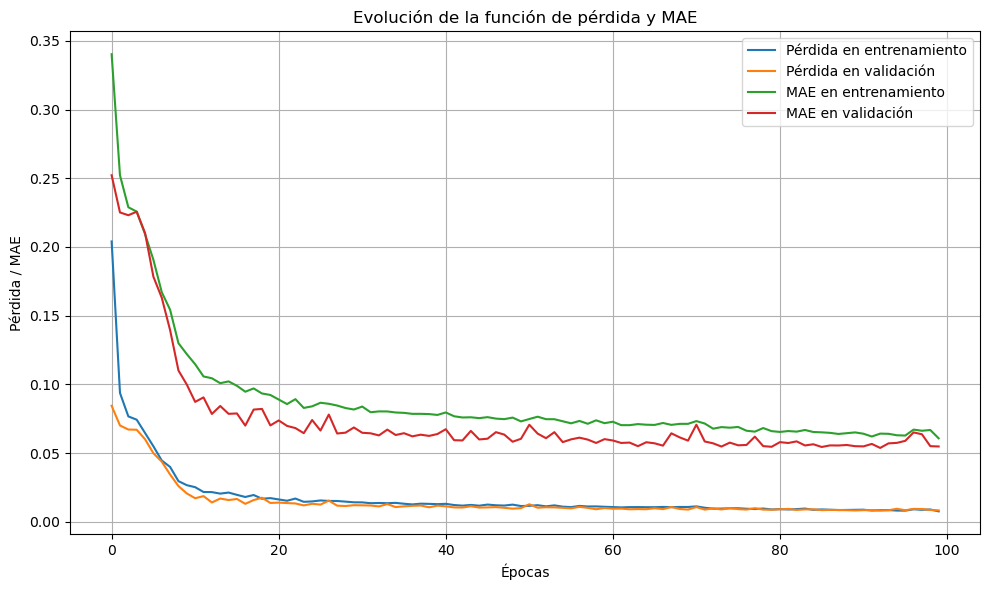

3/3 [==============================] - 1s 323ms/step


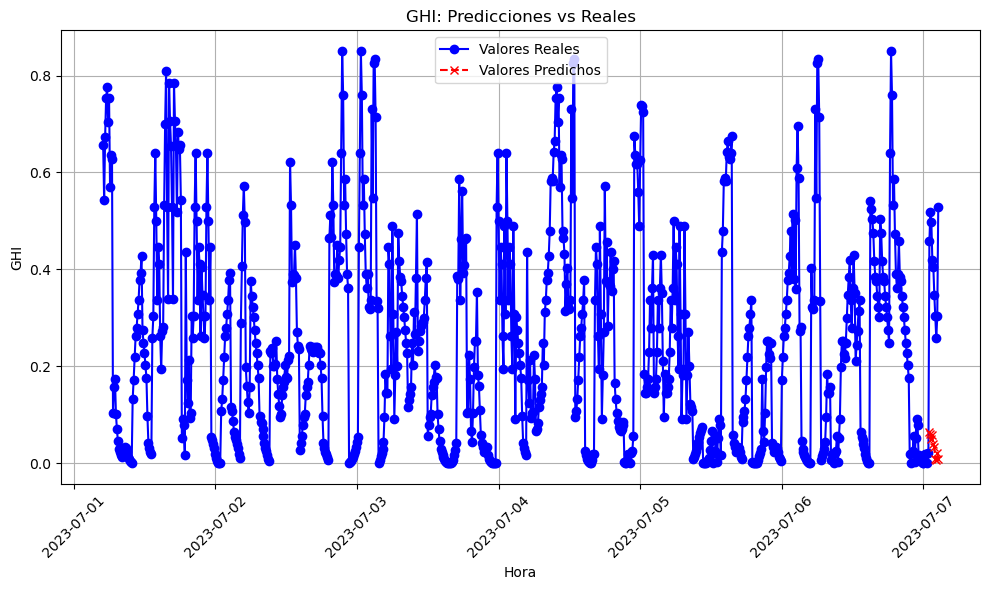

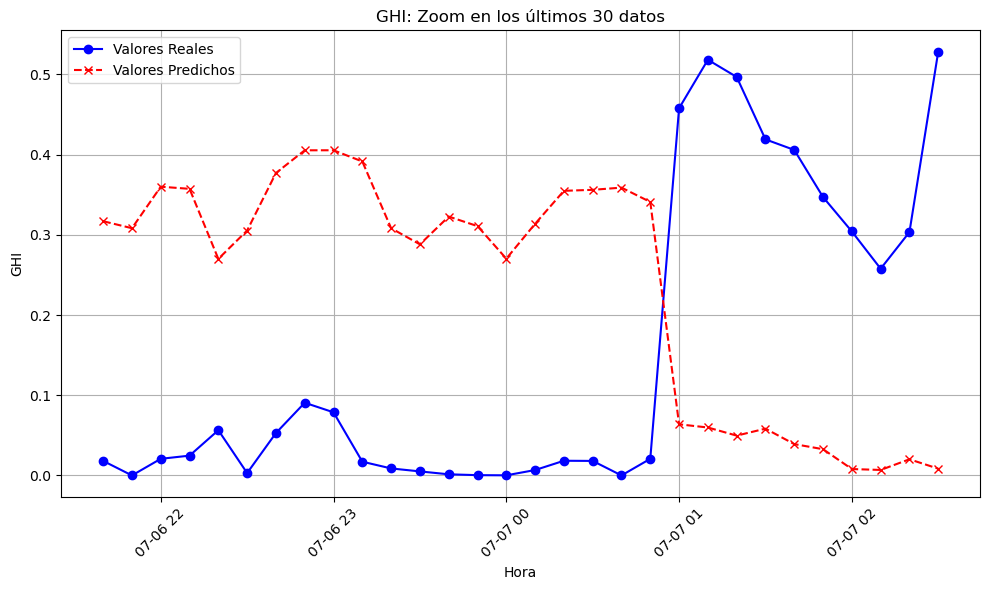

In [3]:
# Cargar el DataFrame
df = pd.read_pickle('df_GHI.plk')

# Asegúrate de que la columna 'Timestamp' sea de tipo datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Definir fechas de inicio y fin para entrenamiento
fecha_inicio = '2023-07-01 05:00:00'
fecha_fin = '2023-07-06 18:20:00'

# Filtrar el DataFrame por el rango de tiempo
df_filtrado = df[(df['Timestamp'] >= fecha_inicio) & (df['Timestamp'] <= fecha_fin)]

# Cargar imágenes y valores GHI junto con DoY Sin y DoY Cos
image_folder = 'Images/ACMF'
X_images, y_ghi, doy_sin, doy_cos, scaler = load_images_and_ghi(df_filtrado, image_folder)

# Definir el valor de seq_len basado en el número de imágenes disponibles
num_imagenes = len(X_images)
num_pred = 10
seq_len = min(60, max(1, num_imagenes - num_pred))

# Crear secuencias de entrada
X_images_seq, X_ghi_seq, X_doy_sin_seq, X_doy_cos_seq, y_ghi_pred = create_sequences(X_images, y_ghi, doy_sin, doy_cos, seq_len, num_pred)

# Dividir los datos en conjunto de entrenamiento y prueba
X_images_seq_train, X_images_seq_test, X_ghi_seq_train, X_ghi_seq_test, X_doy_sin_seq_train, X_doy_sin_seq_test, X_doy_cos_seq_train, X_doy_cos_seq_test, y_ghi_pred_train, y_ghi_pred_test = train_test_split(
    X_images_seq, X_ghi_seq, X_doy_sin_seq, X_doy_cos_seq, y_ghi_pred, test_size=0.2, random_state=42
)

# Concatenar las secuencias numéricas (GHI, DoY Sin, DoY Cos)
X_numeric_seq_train = np.concatenate([X_ghi_seq_train, X_doy_sin_seq_train[..., np.newaxis], X_doy_cos_seq_train[..., np.newaxis]], axis=-1)
X_numeric_seq_test = np.concatenate([X_ghi_seq_test, X_doy_sin_seq_test[..., np.newaxis], X_doy_cos_seq_test[..., np.newaxis]], axis=-1)

# Definir el modelo CNN-LSTM
img_shape = (68, 68, 3)
image_input = Input(shape=(seq_len, *img_shape))
cnn_model = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(image_input)
cnn_model = TimeDistributed(MaxPooling2D((2, 2)))(cnn_model)
cnn_model = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(cnn_model)
cnn_model = TimeDistributed(MaxPooling2D((2, 2)))(cnn_model)
cnn_model = TimeDistributed(Conv2D(128, (3, 3), activation='relu'))(cnn_model)
cnn_model = TimeDistributed(MaxPooling2D((2, 2)))(cnn_model)
cnn_model = TimeDistributed(Flatten())(cnn_model)

# Agregar una capa Dropout para prevenir sobreajuste
cnn_model = Dropout(0.3)(cnn_model)

numeric_input = Input(shape=(seq_len, 3))
concat = Concatenate()([cnn_model, numeric_input])

lstm_out = LSTM(64, return_sequences=False)(concat) # revisar si se debe incluir en una capa densa 
lstm_out = Dropout(0.3)(lstm_out)
output = Dense(num_pred)(lstm_out)

# Definir el modelo
model = Model([image_input, numeric_input], output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit([X_images_seq_train, X_numeric_seq_train], y_ghi_pred_train, epochs=100, batch_size=32, validation_split=0.2)

# Graficar la evolución del entrenamiento
plot_training_history(history)

# Predecir con el modelo entrenado
y_ghi_pred_test_sequential = []
for i in range(10):
    pred = model.predict([X_images_seq_test, X_numeric_seq_test])
    y_ghi_pred_test_sequential.append(pred.flatten())
    X_images_seq_test = np.roll(X_images_seq_test, -1, axis=1)
    X_numeric_seq_test = np.roll(X_numeric_seq_test, -1, axis=1)

y_ghi_pred_test_sequential = np.concatenate(y_ghi_pred_test_sequential)

# Invertir la normalización de los valores predichos y reales
y_ghi_pred_test_inversed = scaler.inverse_transform(y_ghi_pred_test_sequential.reshape(-1, 1)).flatten()
y_ghi_test_inversed = scaler.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).flatten()

# Generar timestamps dinámicamente a partir de la fecha de inicio utilizada en el filtro
timestamps = pd.date_range(start=fecha_inicio, periods=len(y_ghi_test_inversed), freq='10T')

# Graficar los valores reales y predichos
plot_real_vs_predicted(y_ghi_test_inversed, y_ghi_pred_test_inversed[-10:], timestamps)

# Graficar los últimos 30 valores reales y predichos
plot_real_vs_predicted_zoom(y_ghi_test_inversed, y_ghi_pred_test_inversed, timestamps, num_zoom=30)

1/1 [==============================] - 0s 129ms/step


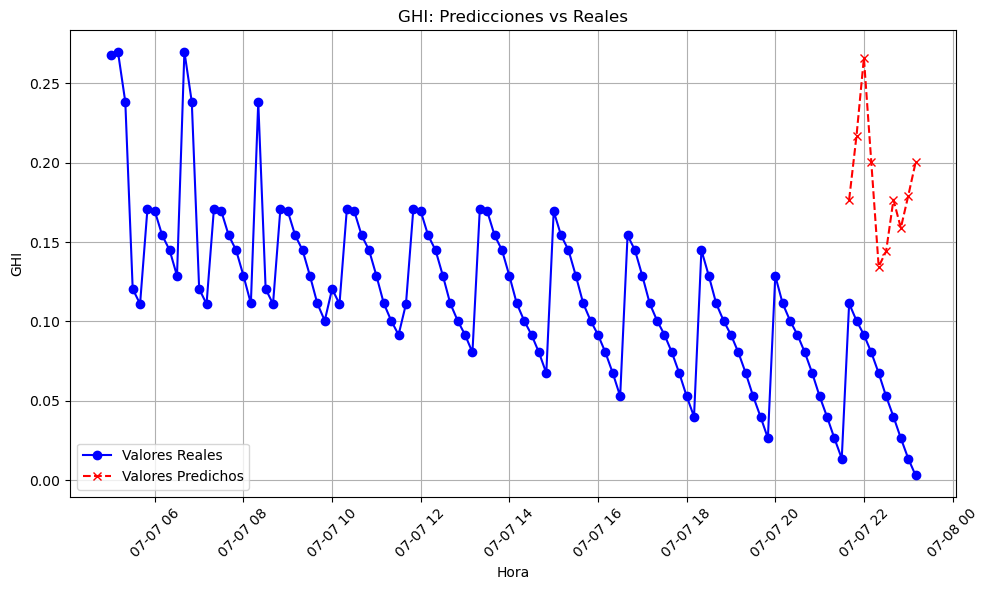

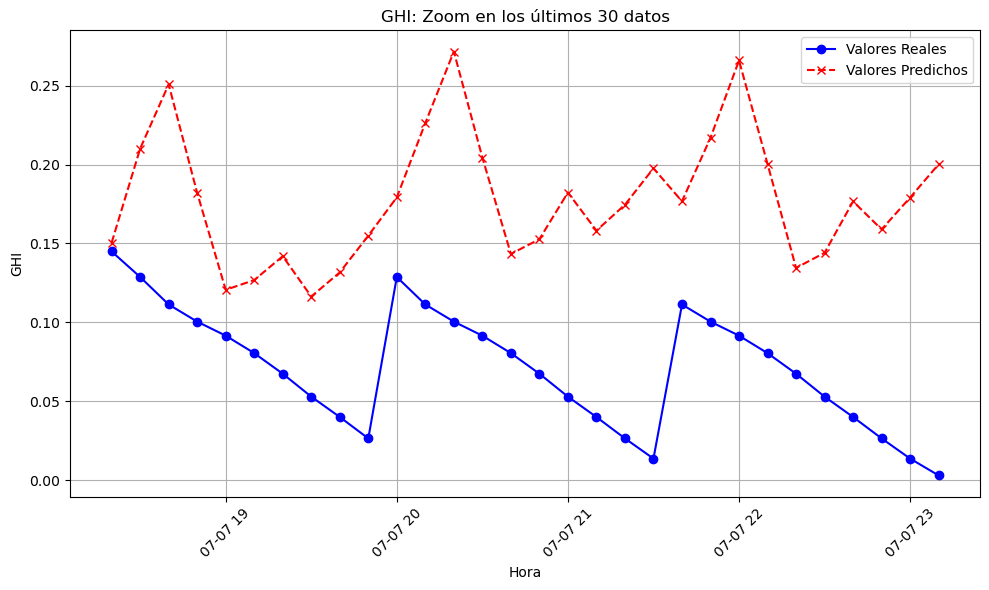

In [7]:
# Definir nuevas fechas para hacer predicciones
nueva_fecha_inicio = '2023-07-07 05:00:00'
nueva_fecha_fin = '2023-07-07 18:20:00'

# Filtrar el DataFrame por el nuevo rango de fechas
df_nuevo_filtrado = df[(df['Timestamp'] >= nueva_fecha_inicio) & (df['Timestamp'] <= nueva_fecha_fin)]

# Cargar las nuevas imágenes y valores GHI junto con DoY Sin y DoY Cos
X_images_nuevas, y_ghi_nuevas, doy_sin_nuevas, doy_cos_nuevas, _ = load_images_and_ghi(df_nuevo_filtrado, image_folder)

# Crear nuevas secuencias de entrada (ajustadas a las nuevas fechas)
X_images_seq_nuevas, X_ghi_seq_nuevas, X_doy_sin_seq_nuevas, X_doy_cos_seq_nuevas, y_ghi_pred_nuevas = create_sequences(
    X_images_nuevas, y_ghi_nuevas, doy_sin_nuevas, doy_cos_nuevas, seq_len, num_pred
)

# Asegurarse de que las secuencias numéricas y de imágenes tengan el mismo tamaño
num_samples_images = X_images_seq_nuevas.shape[0]
num_samples_numeric = X_numeric_seq_test.shape[0]

if num_samples_images != num_samples_numeric:
    min_samples = min(num_samples_images, num_samples_numeric)
    X_images_seq_nuevas = X_images_seq_nuevas[:min_samples]
    X_numeric_seq_test = X_numeric_seq_test[:min_samples]

# Realizar predicciones con el modelo entrenado
y_ghi_pred_nuevas_sequential = []

for i in range(10):
    pred = model.predict([X_images_seq_nuevas, X_numeric_seq_test])
    y_ghi_pred_nuevas_sequential.append(pred.flatten())
    X_images_seq_nuevas = np.roll(X_images_seq_nuevas, -1, axis=1)
    X_numeric_seq_test = np.roll(X_numeric_seq_test, -1, axis=1)

y_ghi_pred_nuevas_sequential = np.concatenate(y_ghi_pred_nuevas_sequential)

# Invertir la normalización de los valores predichos
y_ghi_pred_nuevas_inversed = scaler.inverse_transform(y_ghi_pred_nuevas_sequential.reshape(-1, 1)).flatten()
y_ghi_nuevas_inversed = scaler.inverse_transform(y_ghi_pred_nuevas.reshape(-1, 1)).flatten()

# Generar los timestamps correspondientes al rango de fechas nuevas
timestamps_nuevas = pd.date_range(start=nueva_fecha_inicio, periods=len(y_ghi_nuevas_inversed), freq='10T')

# Graficar las nuevas predicciones vs valores reales para el rango de nuevas fechas
plot_real_vs_predicted(y_ghi_nuevas_inversed, y_ghi_pred_nuevas_inversed[-10:], timestamps_nuevas)

# Graficar zoom en los últimos 30 valores reales y predichos del nuevo rango
plot_real_vs_predicted_zoom(y_ghi_nuevas_inversed, y_ghi_pred_nuevas_inversed, timestamps_nuevas, num_zoom=30)